In [1]:
#モジュール
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [0]:
# 生成器
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim = z_dim))
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv2DTranspose(64,  kernel_size = 3, strides = 1, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv2DTranspose(1, kernel_size = 3 , strides = 2, padding = 'same'))
    model.add(Activation('tanh'))
    
    return model

In [0]:
# 識別器
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32,
                                       kernel_size = 3,
                                       strides = 2,
                                        input_shape = img_shape,
                                        padding = 'same'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv2D(64,
                                        kernel_size = 3,
                                        strides = 2,
                                        input_shape = img_shape,
                                        padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Conv2D(128,
                                        kernel_size = 3,
                                        input_shape = img_shape,
                                        padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model
    

In [0]:
# DCGANの生成&コンパイル
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [0]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                                         optimizer = Adam(),
                                         metrics = ['accuracy'])
generator = build_generator(z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy',
                       optimizer = Adam())

In [0]:
# DCGANの学習
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_,_) = mnist.load_data()
    X_train = X_train /127.5 - 1.0
    X_train = np.expand_dims(X_train, axis = 3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_fake, d_loss_real)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss: %f, acc : %.2f%%] [G loss %f]" %
                     (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            sample_images(generator)
    

In [0]:
def sample_images(generator, image_grid_rows = 4, image_gird_columns=4):
    
    z = np.random.normal(0, 1, (image_grid_rows * image_gird_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                                           image_gird_columns,
                                           figsize = (4,4),
                                           sharey = True,
                                           sharex = True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_gird_columns):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].axis('off')
            cnt += 1

11493376/11490434 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.012192, acc : 100.00%] [G loss 4.452224]
2000 [D loss: 0.031614, acc : 98.83%] [G loss 5.161382]
3000 [D loss: 0.035508, acc : 99.22%] [G loss 5.075418]
4000 [D loss: 0.068407, acc : 98.05%] [G loss 3.021546]
5000 [D loss: 0.113231, acc : 96.88%] [G loss 4.023175]
6000 [D loss: 0.133920, acc : 97.27%] [G loss 2.948154]
7000 [D loss: 0.061287, acc : 99.22%] [G loss 5.809474]
8000 [D loss: 0.087289, acc : 96.09%] [G loss 3.902580]
9000 [D loss: 0.099524, acc : 98.05%] [G loss 4.123703]
10000 [D loss: 0.111719, acc : 98.05%] [G loss 4.128618]
11000 [D loss: 0.194310, acc : 92.97%] [G loss 3.796458]
12000 [D loss: 0.068968, acc : 98.44%] [G loss 6.240995]
13000 [D loss: 0.118805, acc : 96.48%] [G loss 5.925264]
14000 [D loss: 0.310728, acc : 85.94%] [G loss 3.592454]
15000 [D loss: 0.034919, acc : 100.00%] [G loss 5.864703]
16000 [D loss: 0.526950, acc : 75.78%] [G loss 3.168651]
17000 [D loss: 0.106864, acc : 97.27%] [G loss 5.174129]
18000 [D loss: 0.279265, acc : 85.16%]

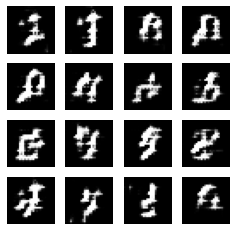

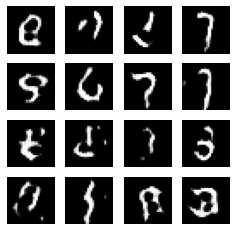

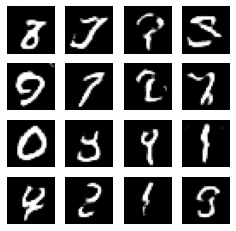

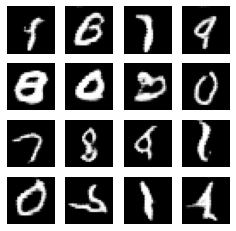

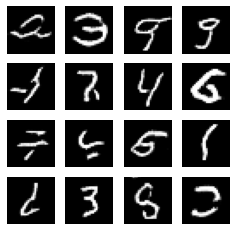

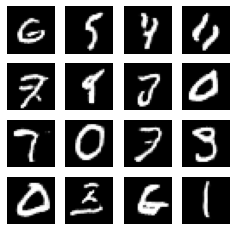

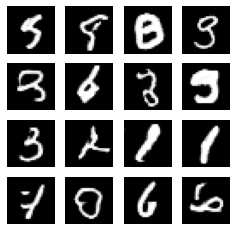

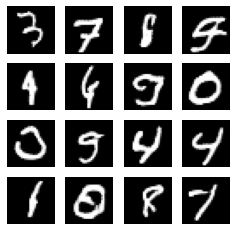

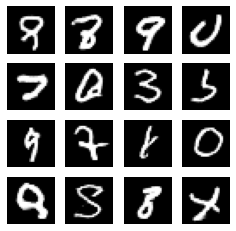

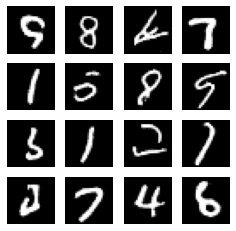

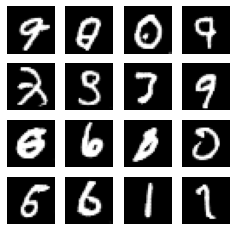

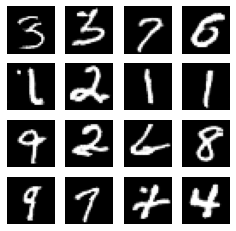

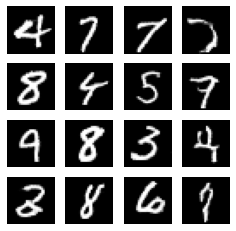

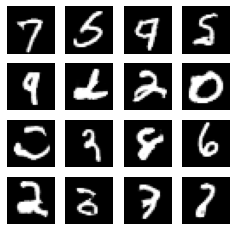

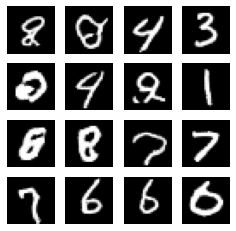

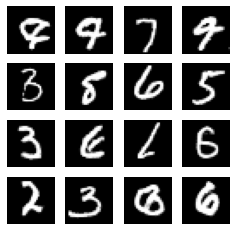

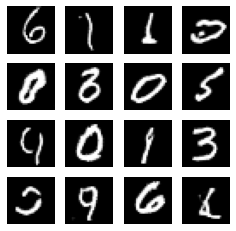

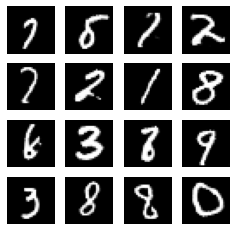

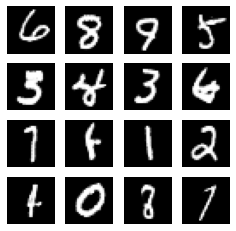

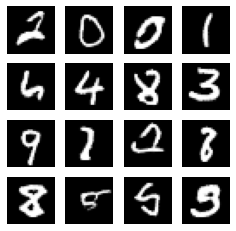

In [9]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)